# 0. Imports and Constants
- Do not forget to select dataset version in the #CONSTANTS# part

In [14]:
############## AUTORELOAD MAGIC ###################
%load_ext autoreload
%autoreload 2
###################################################

############## FUNDAMENTAL MODULES ################
import json
from PIL import Image
import os
import sys
import copy
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
 ##################################################


############## TASK-SPECIFIC MODULES ##############
sys.path.append(os.path.join(os.getcwd(),"src"))
import embed_txtimg_pairs as etp
import TweetNormalizer
import utils
###################################################


############## DATA SCIENCE & ML MODULES ##########
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch
import pandas as pd
from scipy import stats
###################################################

############## CONSTANTS ##########################
version = "v2" #"v1"
user = "patriziopalmisano" #"onurdenizguler"
dataset_directory = f"/Users/{user}/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_{version}"
###################################################


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <font color="Crimson"> 1. Examine and embed a single training datapoint
- This chapter showcases what the model does on an image and should be skimmed through for conceptual understanding

In [15]:
# Load the training set (raw data)
train_jsonl_file = os.path.join(dataset_directory, "CT23_1A_checkworthy_multimodal_english_train.jsonl")

train_set = []
with open(train_jsonl_file, "r") as f:
    for line in f:
       train_set.append(json.loads(line))

Text(0.5, 1.0, 'Original image and tweet')

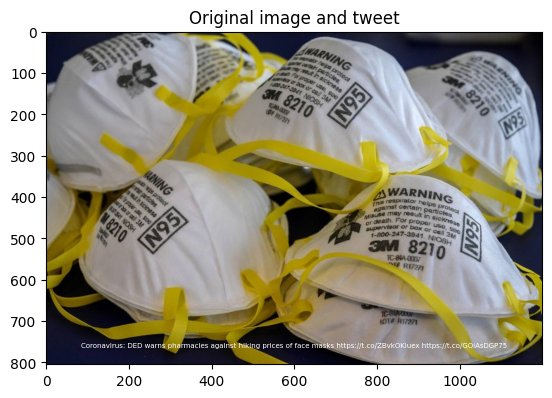

In [16]:
# Examine a single sample from the training set
sample = train_set[0]
tweet_id = sample["tweet_id"]
tweet_text = sample["tweet_text"]
tweet_url = sample["tweet_url"]
img_path = os.path.join(dataset_directory, sample["image_path"])
img = Image.open(img_path)

fig, ax = plt.subplots()
#fig.set_size_inches(15, 15)
ax.imshow(img)
ax.text(0.5, 0.05, tweet_text, transform=ax.transAxes,
        fontsize=5, ha='center', color='white')
plt.title("Original image and tweet")

## <font color="Crimson"> 1.1 Use the model to embed a single sample from the train set
- This chapter showcases what the model does on an image

<font color="Black"> In this implementation we use the following model: "clip-vit-base-patch32". This model differs from the paper implementation in that it uses ViT instead of ResNet. https://huggingface.co/openai/clip-vit-base-patch32

In [17]:
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

### <font color="Crimson"> 1.1.1 Tokenize and embed the tweet

In [18]:
# Create tokens from the tweet text
inputs = tokenizer(tweet_text, return_tensors="pt").to(device)
print("Tokens: ", inputs)

# Embed the tokenized tweet as a single entity into a 512-dim space
text_emb = model.get_text_features(**inputs)
print("\nEmbedding shape: ", text_emb.shape)

Tokens:  {'input_ids': tensor([[49406, 13210,   722,   582,   718,   281,  1241, 14086,  8193,   963,
          1601,  9118,  5954,   539,  1710, 19055, 30901, 12441,   339,   269,
          1320,   270,    89, 18958,  1313,   848,    84,  4118, 30901, 12441,
           339,   269,  1320,   270,   650, 32303,  2394,   335,   278,   276,
         49407]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='mps:0')}

Embedding shape:  torch.Size([1, 512])


### <font color="Crimson"> 1.1.2 Process and embed the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image shape (width, height):  (1200, 805)
Resized image shape:  torch.Size([1, 3, 224, 224])


Text(0.5, 1.0, 'Image after processor transformation')

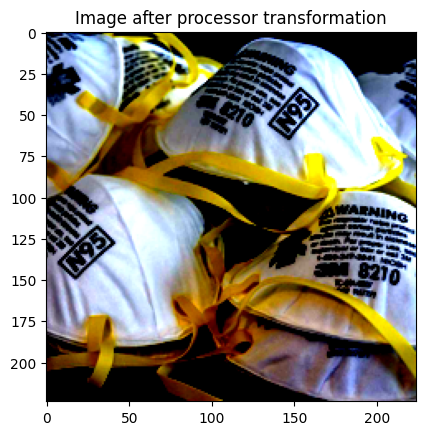

In [19]:
# Resize the image using the processor
image = processor(
    text=None,
    images=img,
    return_tensors='pt'
)['pixel_values'].to(device)
print("Original image shape (width, height): ", img.size)
print("Resized image shape: ", image.shape)

# Display the transformed image
tensor_image_to_display = copy.deepcopy(image)
tensor_image_to_display = tensor_image_to_display.to("cpu")
tensor_image_to_display = tensor_image_to_display.squeeze()
plt.imshow(tensor_image_to_display.permute(1, 2, 0))
plt.title("Image after processor transformation")

In [20]:
# Embed the transformed image
img_emb = model.get_image_features(image)
print("Image embedding shape: ", img_emb.shape)

Image embedding shape:  torch.Size([1, 512])


# <font color="ForestGreen"> 2. Load all data from train/dev/test sets

## <font color="ForestGreen"> 2.1 Load the entire dataset

In [21]:
dataset_directory = "/Users/" + user + "/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_{}"

raw_dataset_v1, texts_v1, imgs_v1, tweet_ids_v1 = utils.load_dataset(dataset_directory.format("v1"))
raw_dataset_v2, texts_v2, imgs_v2, tweet_ids_v2= utils.load_dataset(dataset_directory.format("v2"))

Sizes of train/test/dev txt and img arrays respectively: 
2299 2299
256 256
525 525
Sizes of train/test/dev txt and img arrays respectively: 
2356 2356
271 271
548 548


## <font color="ForestGreen"> 2.1.1 Load gold dataset

In [22]:
gold_dataset_directory = "/Users/" + user + "/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_test_gold"

raw_dataset_gold, texts_gold, imgs_gold, tweet_ids_gold = utils.load_gold_dataset(gold_dataset_directory)


KeyboardInterrupt: 

## <font color="ForestGreen"> 2.2 Examine the differences between v1 and v2 of the dataset

In [22]:
# Examine the delta between v1 and v2 datasets
for split in ["train", "dev", "test"]:
   removed_files = set(tweet_ids_v1[split]).difference(set(tweet_ids_v2[split]))
   added_files = set(tweet_ids_v2[split]).difference(set(tweet_ids_v1[split]))
   print(f"{len(removed_files)} files were removed from {split} split", removed_files)
   print(f"{len(added_files)} new files were added to {split} split", added_files)

251 files were removed from train split {'1033709472647204864', '1034470715955793920', '1222421392936882176', '1222684208226881539', '1035311260869558272', '1033744561976303617', '1033468137646252038', '1222647895746400258', '1222609001785020418', '1032970239514951681', '1222405243557883904', '1222862597084475392', '1032658773037514754', '1222370511159799808', '1222738114306666496', '1207648875529621505', '1143100704095166464', '1222633109528641537', '1222559411392143361', '1222586306716479489', '1222698599202611200', '1222482052924297217', '1033301210886033409', '1168613495027523584', '1222842947768606723', '1222539259015380993', '1222744261483016192', '1222429312210653184', '1199878503950409729', '1032649590481268736', '1253332330254438406', '1222830056424247296', '1222867662084214784', '1222803056284315648', '1222387596514381824', '1222902124238921728', '1035197035023163393', '1193946596284784642', '1033409925509050368', '1032653898048331776', '1182064015603896321', '122285399270049

# <font color="RoyalBlue"> 3. Examine the sequence length issue (for dataset v2 in this edition)

In [24]:
# Load v2 dataset
raw_dataset, texts, imgs, tweet_ids= utils.load_dataset(dataset_directory.format("v2"))

Sizes of train/test/dev txt and img arrays respectively: 
2356 2356
271 271
548 548


In [25]:
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)


# Determine the number of samples having longer than 77 tokens
tokens_train = tokenizer(texts["train"], padding=True, return_tensors="pt")["input_ids"]
tokens_dev = tokenizer(texts["dev"], padding=True, return_tensors="pt")["input_ids"]
tokens_test = tokenizer(texts["test"], padding=True, return_tensors="pt")["input_ids"]

Token indices sequence length is longer than the specified maximum sequence length for this model (376 > 77). Running this sequence through the model will result in indexing errors


In [26]:
excess_tokens_train = []
for idx, item in enumerate(tokens_train):
    seq_length = (item == 49407).nonzero(as_tuple=True)[0][0] + 1#length of sequence inclunding <EOS>
    if seq_length >  77:
        excess_tokens_train.append(seq_length.item() - 77) # record how many tokens would be truncated
excess_tokens_train = np.sort(np.array(excess_tokens_train))

excess_tokens_dev = []
for idx, item in enumerate(tokens_dev):
    seq_length = (item == 49407).nonzero(as_tuple=True)[0][0] + 1#length of sequence inclunding <EOS>
    if seq_length >  77:
        excess_tokens_dev.append(seq_length.item() - 77) # record how many tokens would be truncated
excess_tokens_dev= np.sort(np.array(excess_tokens_dev))

excess_tokens_test = []
for idx, item in enumerate(tokens_test):
    seq_length = (item == 49407).nonzero(as_tuple=True)[0][0] + 1#length of sequence inclunding <EOS>
    if seq_length >  77:
        excess_tokens_test.append(seq_length.item() - 77) # record how many tokens would be truncated
excess_tokens_test= np.sort(np.array(excess_tokens_test))

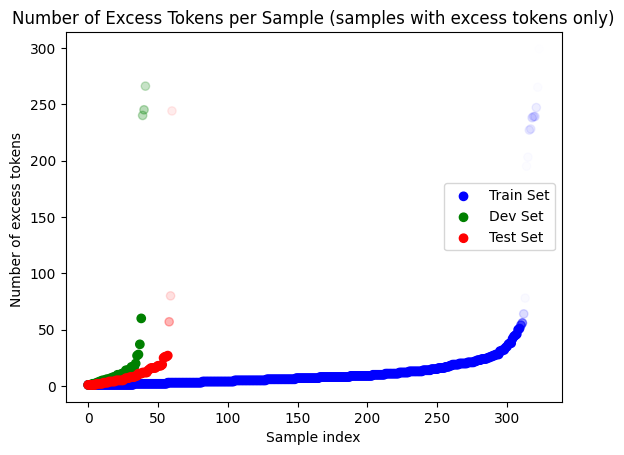

In [27]:
data = [excess_tokens_train, excess_tokens_dev, excess_tokens_test]

# define the colors for each dataset
colors = ['blue', 'green', 'red']
labels = ['Train Set', 'Dev Set', 'Test Set']

# create a figure and axis object
fig, ax = plt.subplots()

# loop through the datasets and plot them as scatter plots
for i in range(len(data)):
    # calculate the density of points in the current dataset
    kde = stats.gaussian_kde(data[i])
    density = kde(data[i])*600
    density[density > 1] = 1
    
    # create a scatter plot for the current dataset, using the density as the alpha value to make the colors darker where there are more points
    ax.scatter(range(len(data[i])), data[i], color=colors[i], alpha=density**2, label=labels[i])

# set axis labels and title
ax.set_xlabel('Sample index')
ax.set_ylabel('Number of excess tokens ')
ax.set_title('Number of Excess Tokens per Sample (samples with excess tokens only)')

# add legend
ax.legend()

# show the plot

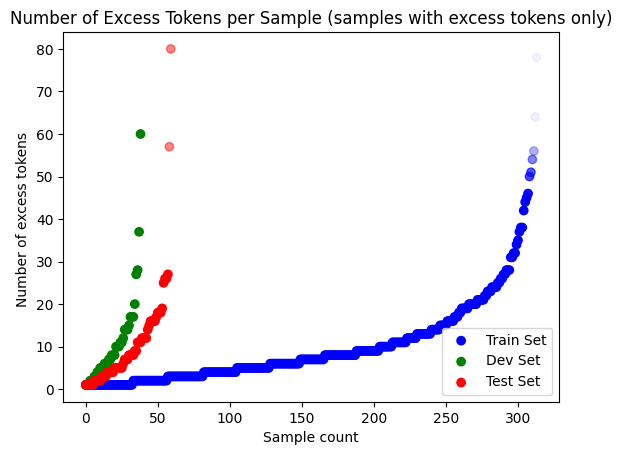

In [28]:
from scipy import stats
# Remove outliers from the data
excess_tokens_train_summary = excess_tokens_train[excess_tokens_train<150]
excess_tokens_dev_summary = excess_tokens_dev[excess_tokens_dev<150]
excess_tokens_test_summary = excess_tokens_test[excess_tokens_test<150]
data = [excess_tokens_train_summary, excess_tokens_dev_summary, excess_tokens_test_summary]

# define the colors for each dataset
colors = ['blue', 'green', 'red']
labels = ['Train Set', 'Dev Set', 'Test Set']

# create a figure and axis object
fig, ax = plt.subplots()

# loop through the datasets and plot them as scatter plots
for i in range(len(data)):
    # calculate the density of points in the current dataset
    kde = stats.gaussian_kde(data[i])
    density = kde(data[i])*600
    density[density > 1] = 1
    
    # create a scatter plot for the current dataset, using the density as the alpha value to make the colors darker where there are more points
    ax.scatter(range(len(data[i])), data[i], color=colors[i], alpha=density**2, label=labels[i])

# set axis labels and title
ax.set_xlabel('Sample count')
ax.set_ylabel('Number of excess tokens ')
ax.set_title('Number of Excess Tokens per Sample (samples with excess tokens only)')

# add legend
ax.legend()

# show the plot

In [29]:
# Find mean-median num. of tokens to be truncated 
all_excess_tokens =  np.concatenate((excess_tokens_train, excess_tokens_dev))
all_excess_tokens = np.concatenate((all_excess_tokens, excess_tokens_test))
print(np.mean(all_excess_tokens))
print(np.median(all_excess_tokens))

18.14519906323185
7.0


# <font color="RoyalBlue"> 4. Resolve the sequence length issue (for dataset v2 in this edition)

In [30]:
# Normalize all tweets using TweetNormalizer()

normalized_texts = {
    "train": [],
    "dev": [],
    "test": []
}
for split in ["train", "dev", "test"]:
    split_texts = texts[split]
    for text in split_texts:
        normalized_text = TweetNormalizer.normalizeTweet(text)
        normalized_texts[split].append(normalized_text)


In [31]:
# Determine the number of normalized samples having longer than 77 tokens

device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

tokens_normalized = {
    "train": [],
    "dev": [],
    "test": []
}

tokens_normalized["train"] = tokenizer(normalized_texts["train"], padding=True, return_tensors="pt")["input_ids"]
tokens_normalized["dev"] = tokenizer(normalized_texts["dev"], padding=True, return_tensors="pt")["input_ids"]
tokens_normalized["test"] = tokenizer(normalized_texts["test"], padding=True, return_tensors="pt")["input_ids"]

excess_tokens_normd = {
    "train": [],
    "dev": [],
    "test": []
}

for split in ["train", "dev", "test"]:
    for idx, item in enumerate(tokens_normalized[split]):
        seq_length = (item == 49407).nonzero(as_tuple=True)[0][0] + 1 #length of sequence inclunding <EOS>
        if seq_length >  77:
            excess_tokens_normd[split].append((idx, seq_length.item() - 77)) #record how many tokens would be truncated from which sample
    excess_tokens_normd[split].sort(key=lambda x: x[1])

excess_tokens_df = pd.DataFrame(excess_tokens_normd["train"]+excess_tokens_normd["dev"] + excess_tokens_normd["test"])
excess_tokens_df["split"] = ["train"]*len(excess_tokens_normd["train"]) + ["dev"]*len(excess_tokens_normd["dev"]) + ["test"]*len(excess_tokens_normd["test"])
excess_tokens_df = excess_tokens_df.rename(columns={0: "sample_idx_in_split", 1: "num_excess_tokens_after_normalization"})
excess_tokens_df = excess_tokens_df[excess_tokens_df.columns[[2,0,1]]]
excess_tokens_df.head(87)

excess_tokens_df["original_tweet"] = [None]*len(excess_tokens_df)
excess_tokens_df["tweet_without_emojis"] = [None]*len(excess_tokens_df)
excess_tokens_df["num_excess_tokens_after_emoji_removal"] = [None]*len(excess_tokens_df)
excess_tokens_df["num_tokens_after_emoji_removal"] = [None]*len(excess_tokens_df) 


Token indices sequence length is longer than the specified maximum sequence length for this model (170 > 77). Running this sequence through the model will result in indexing errors


In [35]:
# Remove emoji explanations and HTTPURL/@USER tokens from tweets with excess tokens

for idx, row in excess_tokens_df.iterrows():
    split = row["split"]
    tweet = normalized_texts[split][row["sample_idx_in_split"]]
    tweet_no_emoji = re.sub("(^|\s):\S.*?\S:", "", tweet)
    excess_tokens_df.loc[idx, "original_tweet"] = tweet


    tokens_no_emoji = tokenizer(tweet_no_emoji, padding=True, return_tensors="pt")["input_ids"][0]
    seq_length = (tokens_no_emoji == 49407).nonzero(as_tuple=True)[0][0] + 1#length of sequence inclunding <EOS>
    if seq_length >  77:
        # Remove multiple occurunces of @USER and HTTPURL
        words = np.array(tweet_no_emoji.split())
        if "@USER" in words:
            words = words[~(words == "@USER")].astype(str).tolist()
            tweet_no_emoji = " ".join(words + ["@USER"])
        words = np.array(tweet_no_emoji.split())
        if "HTTPURL" in words:
            words = words[~(words == "HTTPURL")].tolist()
        tweet_no_emoji = " ".join(words + ["HTTPURL"])
        tokens_no_emoji = tokenizer(tweet_no_emoji, padding=True, return_tensors="pt")["input_ids"][0]
        seq_length = (tokens_no_emoji == 49407).nonzero(as_tuple=True)[0][0] + 1#length of sequence inclunding <EOS>
        if seq_length >  77:
            excess_tokens = seq_length.item() - 77
        else: 
            excess_tokens = 0
    else:
        excess_tokens = 0
    
    excess_tokens_df.loc[idx, "tweet_without_emojis"] = tweet_no_emoji
    excess_tokens_df.loc[idx, "num_excess_tokens_after_emoji_removal"]= excess_tokens
    excess_tokens_df.loc[idx, "num_tokens_after_emoji_removal"]= seq_length.item()

# Get the ids of datapoints with text still longer than 77 tokens
excess_tokens_df.to_excel("excess_tokens_after_normalization.xlsx")

# <font color="Crimson"> 5. Prepare and embed the dataset and pickle the results

In [38]:
# Load dataset
version = "v2"
raw_dataset, texts, imgs, tweet_ids= utils.load_dataset(dataset_directory.format(version))

# Normalize all datapoints 
normalized_texts = {
    "train": [],
    "dev": [],
    "test": []
}
for split in ["train", "dev", "test"]:
    split_texts = texts[split]
    for text in split_texts:
        normalized_text = TweetNormalizer.normalizeTweet(text)
        normalized_texts[split].append(normalized_text)

# Remove text explanations for emojis & repeated HTTPURL & @USER tokens for necessary datapoints 
outlying_datapoints_path = f"/Users/{user}/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_{version}/excess_tokens_after_normalization_{version}.xlsx"
outlying_datapoints_df = pd.read_excel(outlying_datapoints_path)

model_id = "openai/clip-vit-large-patch14"
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

for idx, row in outlying_datapoints_df.iterrows():
    split = row["split"]
    idx_in_split = row["sample_idx_in_split"]
    tweet = normalized_texts[split][row["sample_idx_in_split"]]
    processed_tweet = TweetNormalizer.furtherNormalizeTweet(tweet, tokenizer)
    normalized_texts[split][idx_in_split] = processed_tweet

datapoints_to_truncate_df = outlying_datapoints_df[outlying_datapoints_df["num_excess_tokens_after_emoji_removal"] > 0]
for idx, row in datapoints_to_truncate_df.iterrows():
    split = row["split"]
    sample_idx_in_split = row["sample_idx_in_split"]
    tweet = normalized_texts[split][sample_idx_in_split]
    num_excess_tokens = row["num_excess_tokens_after_emoji_removal"]
    tweet = " ".join(tweet.split()[:-num_excess_tokens])
    while True:
        tokens = tokenizer(tweet)
        if len(tokens["input_ids"]) <= 77: 
            normalized_texts[split][sample_idx_in_split] = tweet
            break
        tweet = " ".join(tweet.split()[:-1])

Sizes of train/test/dev txt and img arrays respectively: 
2356 2356
271 271
548 548
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (140 > 77). Running this sequence through the model will result in indexing errors


In [39]:
# Embed data
embeddings = {
    "train": {
        "txt": None,
        "img": None
    },
    "dev": {
        "txt": None,
        "img": None
    },
    "test": {
        "txt": None,
        "img": None
    }
}

for split in ["train", "test", "dev"]:
    embeddings[split]["txt"], embeddings[split]["img"] = etp.embed_split(normalized_texts[split], imgs[split], batch_size = 8)
    print("Num. files embedded: ", len(embeddings[split]["img"]))
    with open(f'embeddings_{split}_{version}.pickle', 'wb') as handle:
        pickle.dump(embeddings[split], handle, protocol=pickle.HIGHEST_PROTOCOL)


Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

KeyboardInterrupt: 

# <font color="ForestGreen"> 6. Load the pickled embeddings (just for demonstration - demo on dataset v1 embeddings in this edition)

In [3]:
embeddings_train_path = "/Users/onurdenizguler/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_v1/embeddings_train.pickle"
embeddings_test_path = "/Users/onurdenizguler/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_v1/embeddings_test.pickle"
embeddings_dev_path = "/Users/onurdenizguler/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_v1/embeddings_dev.pickle"
with open(embeddings_train_path, 'rb') as handle:
    embeddings_train = pickle.load(handle)
with open(embeddings_dev_path, 'rb') as handle:
    embeddings_dev = pickle.load(handle)
with open(embeddings_test_path, 'rb') as handle:
    embeddings_test = pickle.load(handle)

 # Miscallenous (NOT INCLUDED IN THE REVIEW, JUST EXPERIMENTAL CODE)

##  Display each sample (image + printed tweet on image)

/var/folders/01/g3_km85s2szfllv46j0d2vvw0000gn/T/ipykernel_51229/1779253.py:27: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text)


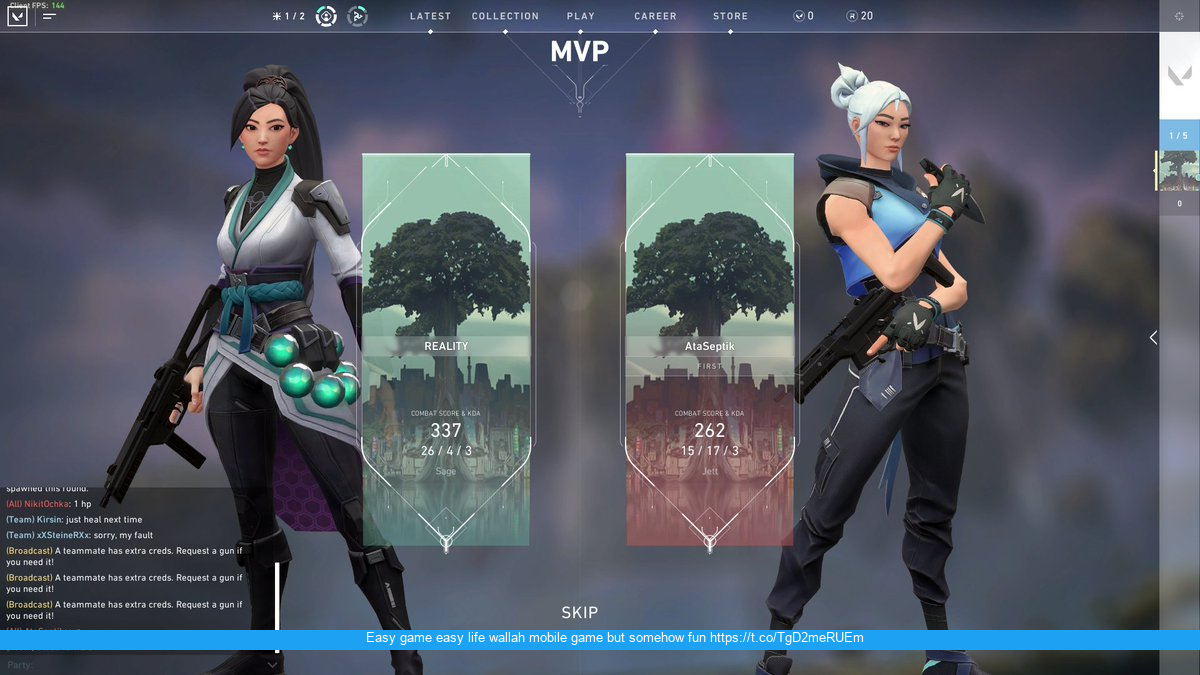

In [377]:
from PIL import Image, ImageDraw, ImageFont

# Open the image file
image = Image.open(img_path)

# Get the image dimensions
width, height = image.size

# Set the font size based on the height of the image
font_size = int(height / 50)

# Create a new ImageDraw object
draw = ImageDraw.Draw(image)

# Choose a font for the text
import platform
if platform.system() == "Darwin":
    font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
else:
    font_path = Arial.ttf
font = ImageFont.truetype(font_path, font_size)

# Define the text to be displayed
text = tweet_text.replace("\n", "")

# Get the width and height of the text
text_width, text_height = draw.textsize(text)

# Calculate the position of the text
x = int((width - text_width) / 2)
y = int(height - text_height - (height / 20))

# Draw a black rectangle with 50% opacity underneath the text
rect_height = int(font_size * 1.5)
rect_y = y + rect_height
draw.rectangle((0, rect_y, width, y), fill=(29, 161, 242, 128))

# Choose a visible color for the text
text_color = (255, 255, 255)

# Draw the text on the image
draw.text((x, y), text, font=font, fill=text_color)

# Display the image
display(image)

In [ ]:
# Collect all train/dev/test raw data, tweets and images (OLD METHOD, WILL BE REMOVED SOON)

raw_dataset = {"train": [], "dev": [], "test": []} 
texts = {"train": [], "dev": [], "test": []} 
imgs = {"train": [], "dev": [], "test": []} 

train_set = []
for split in ["train", "dev", "test"]:
    split_jsonl_file = os.path.join(dataset_directory, f"CT23_1A_checkworthy_multimodal_english_{split}.jsonl")
    with open(split_jsonl_file, "r") as f:
        for line in f:
            raw_dataset[split].append(json.loads(line))
            tweet_text = line["tweet_text"]
            img_path = os.path.join(dataset_directory, line["image_path"])
            img = Image.open(img_path)
            imgs[split].append(img)
            texts[split].append(tweet_text)

texts_train = []
imgs_train = []
for sample in train_set:
    tweet_text = sample["tweet_text"]
    img_path = os.path.join(dataset_directory, sample["image_path"])
    img = Image.open(img_path)
    texts_train.append(tweet_text)
    imgs_train.append(img)

texts_dev = []
imgs_dev = []
for sample in dev_set:
    tweet_text = sample["tweet_text"]
    img_path = os.path.join(dataset_directory, sample["image_path"])
    img = Image.open(img_path)
    texts_dev.append(tweet_text)
    imgs_dev.append(img)

texts_test = []
imgs_test = []
for sample in test_set:
    tweet_text = sample["tweet_text"]
    img_path = os.path.join(dataset_directory, sample["image_path"])
    img = Image.open(img_path)
    texts_test.append(tweet_text)
    imgs_test.append(img)


print("Sizes of train/test/dev txt and img arrays respectively: ")
print(len(texts_train), len(imgs_train))
print(len(texts_dev), len(imgs_dev))
print(len(texts_test), len(imgs_test))

texts = {
    "train": texts_train,
    "dev": texts_dev,
    "test": texts_test
}

imgs = {
    "train": imgs_train,
    "dev": imgs_dev,
    "test": imgs_test
}